# Лабораторная работа 4. Цифровая обработка изображений.

В этой работе рассматриваются различные виды цифровой обработки изображений.

Цель лабораторной работы:
1. Бинаризация
2. Выделение границ


In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? yes


In [2]:
import sys
sys.path.append('../')
%matplotlib inline
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from utility import util

# Изменим стандартный размер графиков matplotlib
plt.rcParams["figure.figsize"] = [6, 4]

## 1 Бинаризация

В обработке изображений часто используется процедура пороговой бинаризации -- разбиения изображения на две области, одна из которых содержит все пиксели со значением ниже некоторого порога, а другая содержи все пиксели со значением выше этого порога.
Оптимальная пороговая сегментация основана на приближении гистограммы изображения к некоторой кривой с использованием весовых сумм двух или более вероятностей интенсивности с нормальным распределением. Тогда порог - это набор ближайших уровней яркости, соответствующих минимуму вероятности между максимумами двух или более нормальных распределений.


<img src="../content/binarization_examle.png" width="800"/>

Примеры бинаризации изображений будем рассматривать на изображении хлорелл под микроскопом


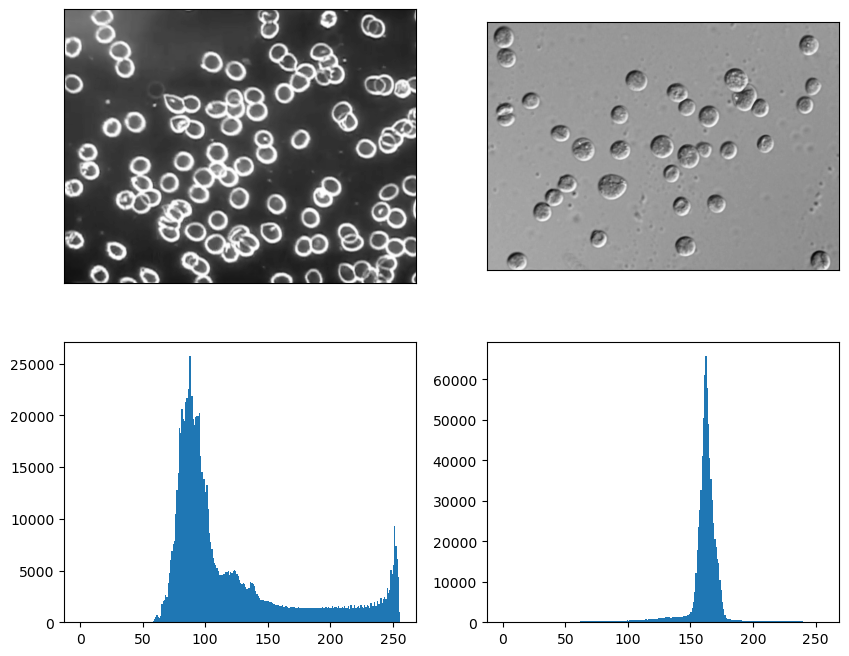

In [5]:
image1 = cv.imread('../images/bloodcells.png')
image2 = cv.imread('../images/chlorella.png')
rgb_image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
hsv_image1 = cv.cvtColor(image1, cv.COLOR_BGR2HSV)
gray_image1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
rgb_image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
hsv_image2 = cv.cvtColor(image2, cv.COLOR_BGR2HSV)
gray_image2 = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)

channels = [0]
histSize = [256]
range = [0, 256]

gs = plt.GridSpec(2, 2)
plt.figure(figsize=(10, 8))
plt.subplot(gs[0])
plt.imshow(gray_image1, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.subplot(gs[1])
plt.imshow(gray_image2, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.subplot(gs[2])
plt.hist(gray_image1.reshape(-1), 256, range)
plt.subplot(gs[3])
plt.hist(gray_image2.reshape(-1), 256, range)
plt.show()




### 1.1 Бинаризация полутоновых изображений (пороговая фильтрация).

Рассмотрим простую бинаризацию на примере полутонового изображения.

Бинаризация полутоновых изображений осуществляется просто. Для каждого пикселя применяется одно и то же пороговое значение. Если значение пикселя меньше порогового значения, оно имеет значение 0, в противном случае — максимальное значение. В библиотеке OpenCV есть функция для бинаризации изображений cv.threshold(), для применения пороговых значений. Функция принимает несколько параметров:
- image -- изображение, к которому применяется бинаризация;
- threshold -- пороговое значение;
- maxval -- максимальное значение, которое присваивается значениям пикселей, превышающим пороговое значение;
- type -- тип порога.

OpenCV предоставляет различные типы пороговых значений:
- cv.THRESH_BINARY
$$
\begin{equation*}
out(x, y) =
 \begin{cases}
   maxval \; &\textit{if image(x, y) > threshold } \\
   0 \; &\textit{иначе}
 \end{cases}
\end{equation*}
$$
- cv.THRESH_BINARY_INV
$$
\begin{equation*}
out(x, y) =
 \begin{cases}
   0 \; &\textit{if image(x, y) > threshold } \\
   maxval \; &\textit{иначе}
 \end{cases}
\end{equation*}
$$
- cv.THRESH_TRUNC
$$
\begin{equation*}
out(x, y) =
 \begin{cases}
   threshold \; &\textit{if image(x, y) > threshold } \\
   image(x,y) \; &\textit{иначе}
 \end{cases}
\end{equation*}
$$
- cv.THRESH_TOZERO
$$
\begin{equation*}
out(x, y) =
 \begin{cases}
   image(x, y) \; &\textit{if image(x, y) > threshold } \\
   0 \; &\textit{иначе}
 \end{cases}
\end{equation*}
$$
- cv.THRESH_TOZERO_INV
$$
\begin{equation*}
out(x, y) =
 \begin{cases}
   0 \; &\textit{if image(x, y) > threshold } \\
   image(x, y) \; &\textit{иначе}
 \end{cases}
\end{equation*}
$$

Подробнее по типам смотри [документацию](https://docs.opencv.org/4.x/d7/d1b/group__imgproc__misc.html#gaa9e58d2860d4afa658ef70a9b1115576)



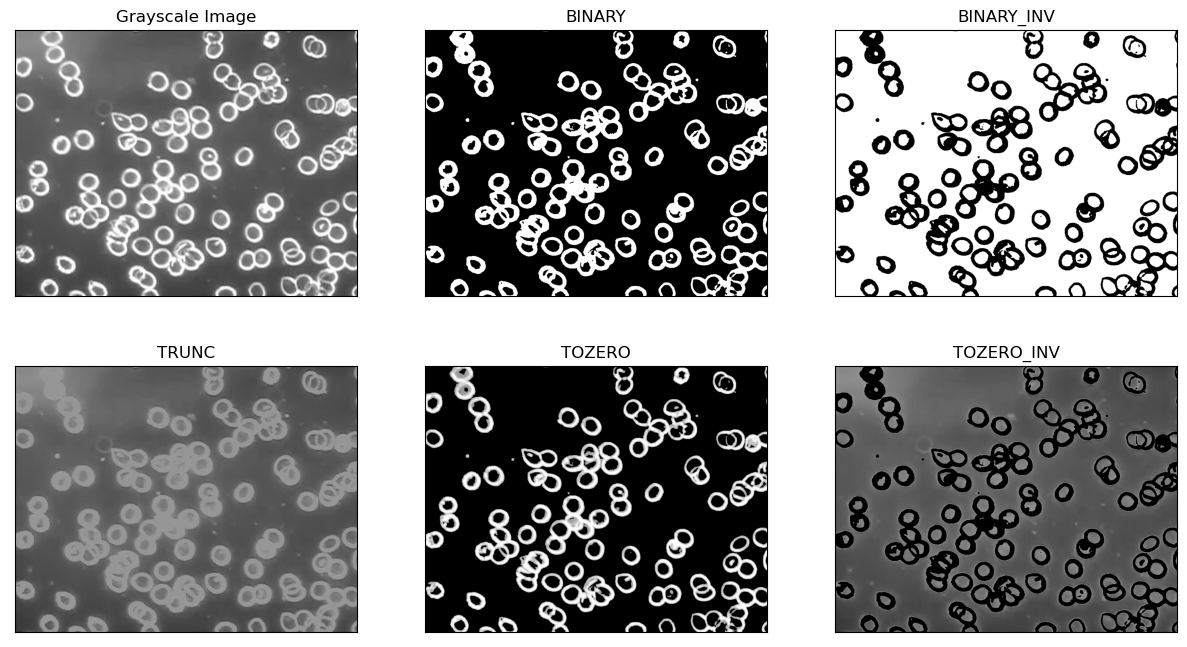

In [6]:
threshold = 150
image = gray_image1

ret, thresh1 = cv.threshold(image, threshold, 255, cv.THRESH_BINARY)
ret, thresh2 = cv.threshold(image, threshold, 255, cv.THRESH_BINARY_INV)
ret, thresh3 = cv.threshold(image, threshold, 255, cv.THRESH_TRUNC)
ret, thresh4 = cv.threshold(image, threshold, 255, cv.THRESH_TOZERO)
ret, thresh5 = cv.threshold(image, threshold, 255, cv.THRESH_TOZERO_INV)
titles = ['Grayscale Image', 'BINARY', 'BINARY_INV', 'TRUNC', 'TOZERO', 'TOZERO_INV']
images = [image, thresh1, thresh2, thresh3, thresh4, thresh5]
plt.figure(figsize=(15, 8))
for i in np.arange(len(images)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], 'gray', vmin=0, vmax=255)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

### Задание: реализуйте пороговую фильтрацию при помощи NumPy.

### 1.2 Бинаризация Оцу (Otsu's Binarization)

Для определения оптимального порога бинаризации предложено большое количество различных подходов. Наиболее удачным из них является подход Оцу, который предполагает не только определение оптимального порога бинаризации, но и вычисление некоторого критерия бимодальности, т.е оценку того, действительно ли исследуемая гистограмма содержит именно две моды (два выраженных пика).
Подробнее про метод Оцу и алгоритм его работы можно почитать [здесь](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html) и [здесь](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%9E%D1%86%D1%83)

Для использования этого метода в opencv используется таже функция cv.threshold(), в которой в качестве дополнительного флага передается параметр cv.THRESH_OTSU. Пороговое значение может быть выбрано произвольным. Затем алгоритм находит оптимальное пороговое значение, которое возвращается в качестве первого значения кортежа.

Работу метода Оцу рассмотрим на примере:


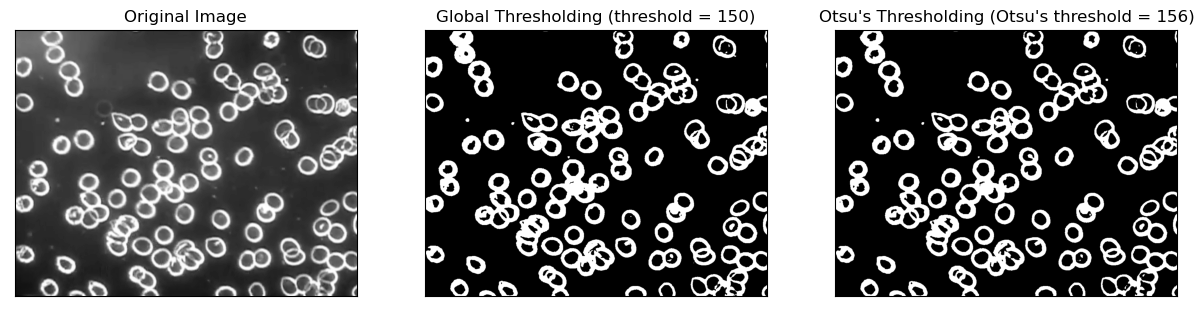

In [7]:
threshold = 150
ret1, thresh1 = cv.threshold(image, threshold, 255, cv.THRESH_BINARY)
ret2, thresh2 = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
titles = ['Original Image', 'Global Thresholding (threshold = %d)' % threshold,
          "Otsu's Thresholding (Otsu's threshold = %d)" % ret2]
images = [image, thresh1, thresh2]

plt.figure(figsize=(15, 8))
for i in np.arange(len(images)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

### 1.3 Адаптивная бинаризация.

В простой полутоновой бинаризации в качестве порога используется одно значение. Но это может быть не во всех случаях, например, если изображение имеет разные условия освещения в разных областях. В этом случае может помочь адаптивное пороговое значение. Здесь алгоритм определяет порог для пикселя на основе небольшой области вокруг него. Таким образом, мы получаем разные пороги для разных областей одного и того же изображения, что дает лучшие результаты для изображений с различной освещенностью.

Помимо описанных выше параметров, метод `cv.adaptiveThreshold()` принимает три входных параметра:

- **AdaptiveMethod** решает, как вычисляется пороговое значение:
    + `cv.ADAPTIVE_THRESH_MEAN_C`: Пороговое значение представляет собой среднее значение площади окрестностей минус константа C.
    + `cv.ADAPTIVE_THRESH_GAUSSIAN_C`: Пороговое значение представляет собой гауссово-взвешенную сумму значений окрестностей минус константа C.
- **BlockSize** определяет размер области соседства, а C — константа, которая вычитается из средней или взвешенной суммы соседних пикселей.

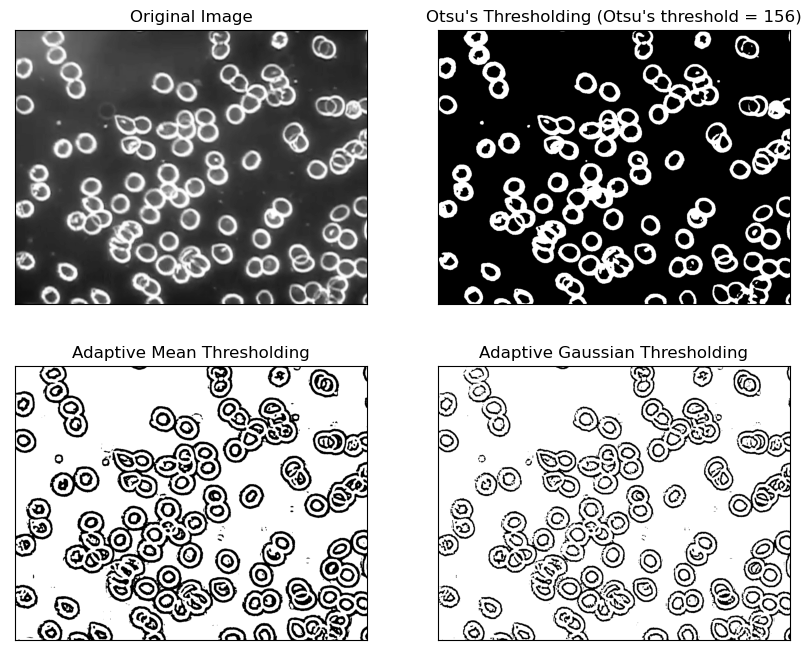

In [8]:
ret1, thresh1 = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
thresh2 = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 15, 5)
thresh3 = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 15, 5)
titles = ['Original Image', "Otsu's Thresholding (Otsu's threshold = %d)" % ret1,
          'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [image, thresh1, thresh2, thresh3]

plt.figure(figsize=(10, 8))
for i in np.arange(len(images)):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

### 1.4 Сегментация многомодальных изображений (Мультипороговая гистограммная бинаризация)

<img src="../content/multimodal_segmentation.png" width="800"/>

Сегментация многомодальных изображений - специально разработанный для данного класса задач, метод статистического выделения мод позволяет оценивать количество и степень выраженности мод гистограммы, опираясь на соответствующий график статистической производной (функции локальной разделимости), представляющий собой график значений критерия Оцу, вычисляемых в локальном скользящем окне, согласованном по ширине с ожидаемой шириной моды гистограммы.


# 2 Выделение границ.

Традиционно, рассматриваются две модели краев: "ступенька" и "излом". Точкам контура типа "ступенька" соответствуют точки смены знака второй производной, а точкам контура типа "излом" - точки смены знака первой производной изображения. Здесь делается допущение, что изображение это непрерывная и два раза дифференцируемая функция f(x,y). В действительности это допущение будет корректным, если перед взятием производной - изображение сгладить (отфильтровать) тем или иным способом.

Из методов обнаружения края при помощи различных дифференциальных операторов наиболее известны операторы Робертса (Roberts), Собеля (Sobel), Канни (Canny), оператор Лапласа и Лапласиан Гаусcиана (LoG).

## 2.1 Операторы вычисления векторов градиентов

Операторы Робертса и Собеля реализуются путем свертки изображения со следующими ядрами:

- Оператор Робертса:
$
M_1 =
 \begin{pmatrix}
  1 & 0 \\
  0 & -1
 \end{pmatrix}
;
M_2 =
 \begin{pmatrix}
  0 & -1\\
  1 & 0
 \end{pmatrix}
.
$

- Оператор Собеля:
$
M_x =
\begin{pmatrix}
 1 & 0 & -1 \\
 2 & 0 & -2 \\
 1 & 0 & -1
 \end{pmatrix}
;
M_y =
\begin{pmatrix}
 1  & 2  & 1 \\
 0  & 0  & 0 \\
 -1 & -2 & -1
 \end{pmatrix}
.
$

Исследования показали, что оператор Робертса не является в достаточной мере помехозащищенным. Оператор Собеля обеспечивает вполне удовлетворительные результаты при обработке реальных изображений.
В каждой точке изображения приближённое значение величины градиента можно вычислить путём использования полученных приближенных значений производных:
$ G = \sqrt{G^2_x + G^2_y} $,
где $ G_x = M_x * Image $, а  $ G_y = M_y * Image $
Символ $*$ здесь - это операция свертки.
Используя эту информацию, мы можем также вычислить направление градиента:
${\displaystyle \mathbf {\Theta } =\operatorname {arctan} \left({\mathbf {G} _{y} \over \mathbf {G} _{x}}\right)} $,
где, к примеру, угол Θ равен нулю для вертикальной границы, у которой тёмная сторона слева.


In [11]:
image1 = cv.imread('../images/lenna.png')
gray_image1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
rgb_image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)

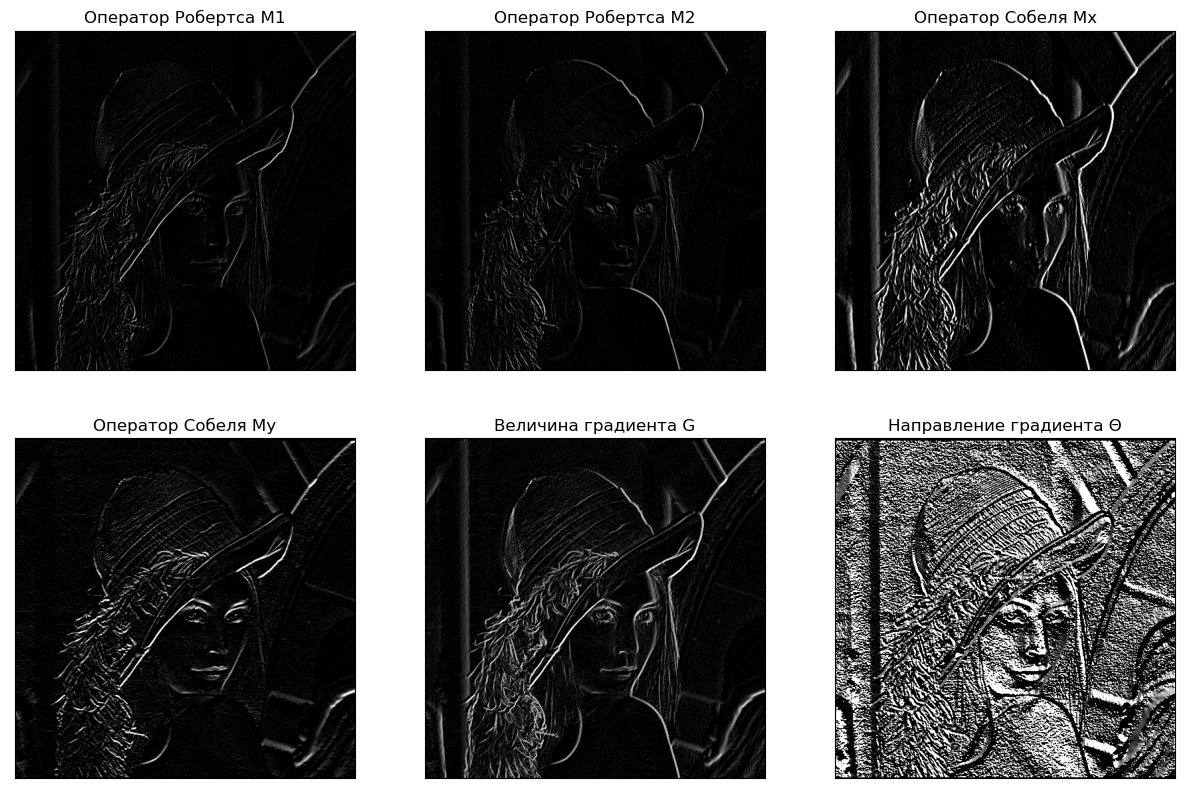

In [12]:
M1 = np.asarray([[1, 0], [0, -1]])
M2 = np.asarray([[0, -1], [1, 0]])
Mx = np.asarray([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
My = np.asarray([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

kernels = [M1, M2, Mx, My]

gs = plt.GridSpec(3, 3)
plt.figure(figsize=(15, 15))

titles = ['Оператор Робертcа M1', 'Оператор Робертcа M2', 'Оператор Собеля Mх',
          'Оператор Собеля My', 'Величина градиента G', 'Направление градиента Θ']
numberOfImage = 6
shape = gray_image1.shape
filtered_images = np.empty(shape[0] * shape[1] * numberOfImage).reshape(shape[0], shape[1], numberOfImage)

for i in np.arange(numberOfImage - 2):
    filtered_images[..., i] = cv.filter2D(gray_image1, -1, kernels[i])

filtered_images[..., 4] = np.sqrt(filtered_images[..., 2] ** 2 + filtered_images[..., 3] ** 2)
filtered_images[..., 5] = np.arctan2(filtered_images[..., 3], filtered_images[..., 2])

for i in np.arange(numberOfImage):
    plt.subplot(gs[i])
    plt.xticks([]), plt.yticks([])
    plt.title(titles[i])
    plt.imshow(filtered_images[..., i], cmap='gray')

plt.show()

## 2.2 Операторы Лапласа и Лапласиан Гауссиана
Рассмотрим операторы выделения краев на, основанных на вычислении производных.

Простейшим оператором такого рода является оператор Лапласа.

**оператор Лапласа** (Лапласиан) - это дифференциальный оператор, который является обобщением на функции нескольких переменных второй производной функции одной переменной. Обозначается символом $\Delta$. Оператор Лапласа примененный к некоторой функции F ставит в соответствие функцию:
$\Delta F = \frac{\partial^2 F}{\partial x^2_1} + \frac{\partial^2 F}{\partial x^2_2} + \dots + \frac{\partial^2 F}{\partial x^2_n}$ для n-мерного пространства. В случае пространственной обработки изображений чаще всего $n=2$.

Ядро лапласиана размером 3x3 выглядит так:
$$
 \begin{pmatrix}
  -1 & -1 & -1 \\
  -1 & 8 & -1 \\
  -1 & -1 & -1
 \end{pmatrix}
$$
Эта маска позволяет в равной степени учитывать возможные перепады яркости во всех направлениях.

**Лапласиан Гауссиана (LoG)** - это оператор выделения краев ступенчатого типа основанный на использовании оператора Лапласа, примененного после сглаживания изображения гауссовским линейным фильтром или непосредственно осуществляется свертка с маской $\Delta G(\sigma,x,y)$. Этот фильтр также известен как *разность гауссовских распределений* (difference of Gaussians ,DoG), т.к. форма маски $\Delta G(\sigma,x,y)$ хорошо аппроксимируется разностью гауссовских масок $G(\sigma_1) - G(\sigma_2)$ с соотношением $\frac{\sigma_1}{\sigma_2} = 1.7$.

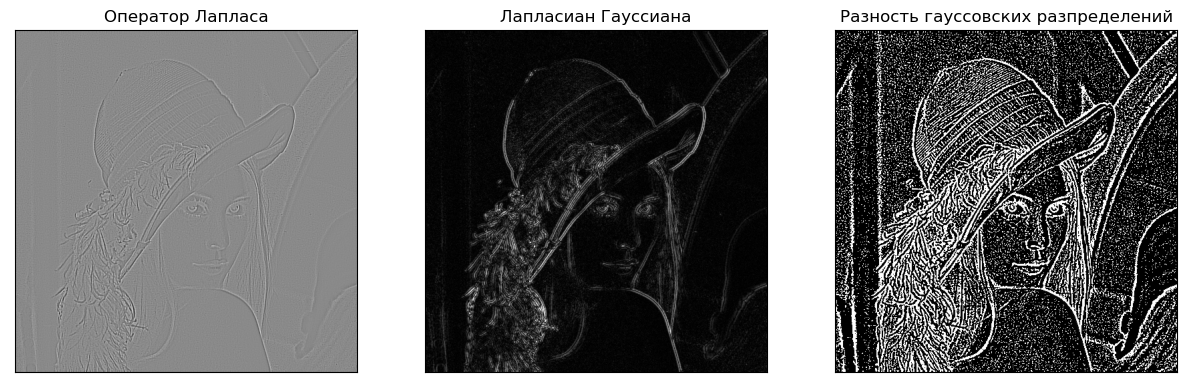

In [18]:
outImageDepth = cv.CV_16S  # глубина результирующего изображения. 
#Т.к. входное изображение 8-битное, 
#чтобы избежать переполнения сделаем выходное изображение 16-битное.

gaussian33 = cv.GaussianBlur(gray_image1, (3, 3), 0)
gaussian55 = cv.GaussianBlur(gray_image1, (5, 5), 0)

# применяем оператор Лапласа к тестовому изображению
laplace = cv.Laplacian(gray_image1, outImageDepth, ksize=3)
# laplace = cv.convertScaleAbs(laplace)
# вычисляем разность гауссовских разпределений
dog = gaussian33 - gaussian55
# dog = cv.convertScaleAbs(dog)
# вычисляем Лапласиан Гауссиана
log = cv.Laplacian(gaussian33, outImageDepth, ksize=3)
log = cv.convertScaleAbs(log)

# вывод
plt.figure(figsize=(15, 8))
gs = plt.GridSpec(1, 3)

titles = ['Оператор Лапласа', 'Лапласиан Гауссиана', 'Разность гауссовских распределений']
outImages = [laplace, log, dog]

for i in np.arange(len(outImages)):
    plt.subplot(gs[i])
    plt.xticks([]), plt.yticks([])
    plt.title(titles[i])
    plt.imshow(outImages[i], cmap='gray')

plt.show()

## 2.3 Оператор Канни
Оператор Канни использует многоступенчатый алгоритм для обнаружения границ в изображениях.
Алгоритм Канни состоит из следующих шагов:
- сглаживание изображения;
- вычисление градиента. Используются четыре фильтра для обнаружения горизонтальных, вертикальных и диагональных ребер в размытом изображении;
- подавление немаксимумов. Только локальные максимумы отмечаются как границы;
- двойная пороговая фильтрация. Потенциальные границы определяются порогами;
- трассировка области неоднозначности. Итоговые границы определяются путём подавления всех краёв, не связанных с определенными (сильными) границами.

К счастью, нам не нужно реализовывать алгоритм Канни, т.к. его реализация есть в OpenCV.
Алгоритм Канни реализован в OpenCV в функции Canny. Для его настройки его работы нужно передать функции два порога.
Подробнее про алгоритм Канни можно почитать в [документации](https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html)

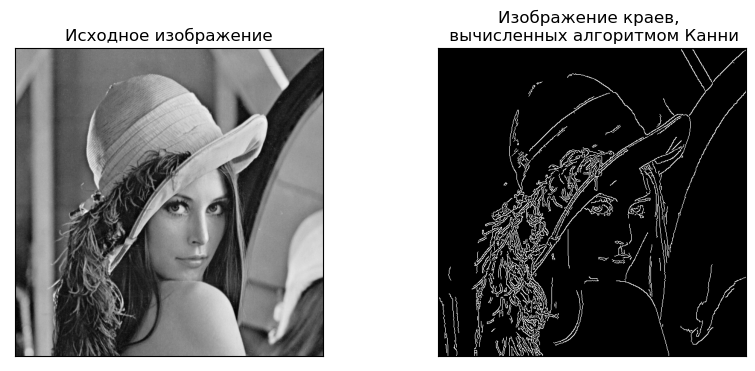

In [14]:
threshold1 = 100
threshold2 = 200
edges = cv.Canny(gray_image1, threshold1, threshold2)

# вывод
plt.figure(figsize=(10, 4))
plt.subplot(121), plt.imshow(gray_image1, cmap='gray')
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(edges, cmap='gray')
plt.title('Изображение краев, \n вычисленных алгоритмом Канни'), plt.xticks([]), plt.yticks([])
plt.show()